<ipython-input-3-3324dd0bb9d9>:48: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  cmap_view.set_bad(alpha=0)
<ipython-input-3-3324dd0bb9d9>:49: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("cool"))
  cmap_pixel.set_bad(alpha=0)


x, y:  200 200
search index:  16251
index:  16251
(330, 285)


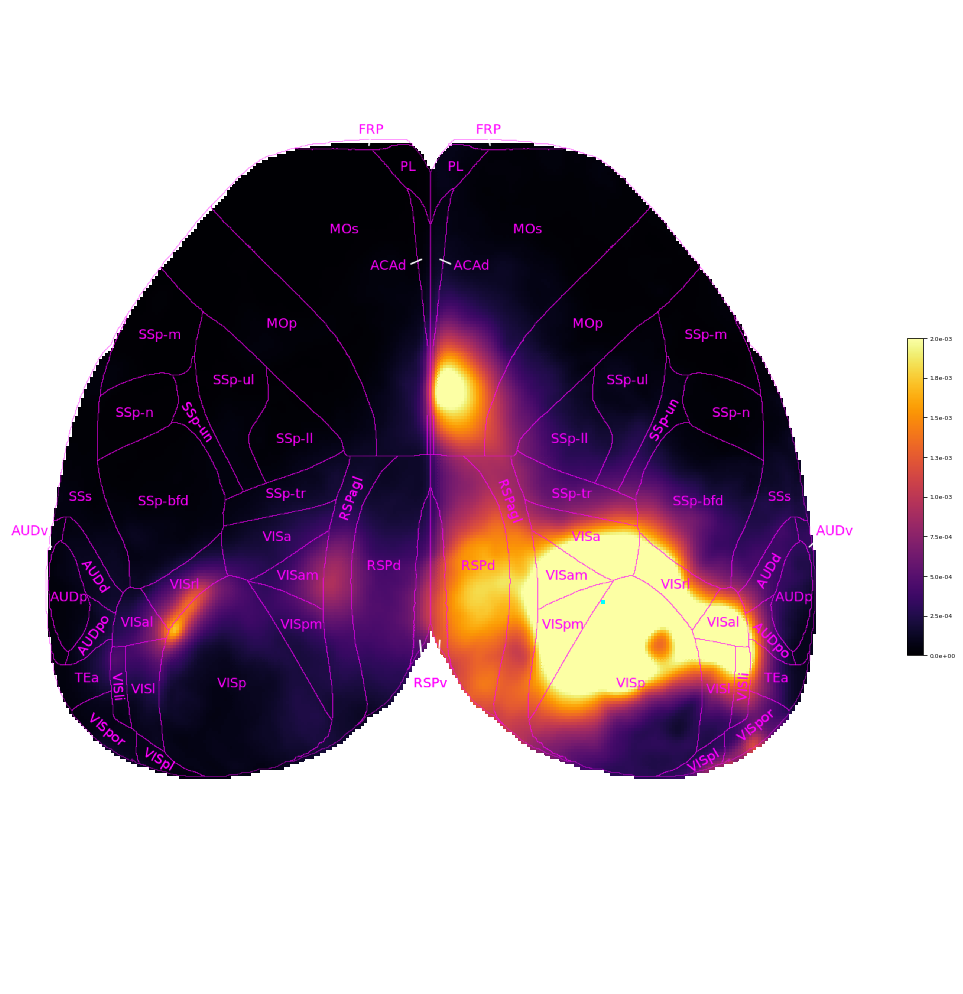

In [3]:
import os
import argparse
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
from matplotlib import gridspec
import sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 
import util.load_mat as load_mat
import palettable 




parser = argparse.ArgumentParser(description='Plot dominant factors of connectome solution')
# Arguments
parser.add_argument('testname',         type=str, nargs=1, help='Name of test to plot. "flatmap" or "top_view"')
parser.add_argument('solution_name',    type=str, nargs=1, help='Name of .mat solution file, including or excluding file extension.')
parser.add_argument('path_to_solution', type=str, nargs=1, help='Dir path where solution is located')
parser.add_argument('n',                type=str, nargs=1, help='number of factors to plot')
# Flags
parser.add_argument('-greedy', action='store_true', help='Search ../lowrank_connectome/data for solution.')
parser.add_argument('-nneg',    action='store_true', help='Plot reordered & scaled solution, rather than scaled QR decomposition.')


def plot_svectors(U, V, testname, output_name, n, nneg=False):
    '''
    Maps voxel coordinates to show connection patterns for n factors.

    Parameters:
        U (int arr): target shape (nx * r)
        V (int arr): source shape (r * ny)
        testname (str) : 'flatmap' or 'top_view'
        output_name (str) : part of outputted file's name
        n (int) : number of factors to create
    Optional parameters:
        nneg (bool) : indicates a nonnegative solution
    '''
    voxel_coords_source, voxel_coords_target, view_lut = load_mat.load_voxel_coords(testname)
    # colormaps
    cmap_view = matplotlib.cm.inferno
    cmap_pixel = matplotlib.cm.cool
    cmap_view.set_bad(alpha=0)
    cmap_pixel.set_bad(alpha=0)
    
    if(nneg):

        Q1 = U.copy()
        Q2 = (V.T).copy()

        r = Q1.shape[1]
        factor_norms_sq = np.zeros(r)

        for rank in range(r):
            
            Q1_r = Q1[:, rank]
            Q2_r = Q2[:, rank]
            Q2_norm = np.linalg.norm(Q2_r)

            factor_norms_sq[rank] = np.linalg.norm(Q1_r) *Q2_norm 

            Q1[:, rank] *= Q2_norm
            Q2[:, rank] /= Q2_norm

        indexlist = np.argsort(-1*factor_norms_sq)
        Q1 = Q1[:, indexlist]
        Q2 = Q2[:, indexlist]
    else:

        Q1, R1 = np.linalg.qr(U, mode='reduced')
        Q2, R2 = np.linalg.qr(V.T)
        u, S, vh = np.linalg.svd(R1 @ (R2.T) )
        Q1 = Q1 @ u * S
        Q2 = Q2 @ vh.T
        
    # specifying x&y coordinates
    x = 200
    y = 200
    # index of W_i that produces a plot for connectivity to voxel at x,y
    search_index = np.where((voxel_coords_source[:, 0] == x) & (voxel_coords_source[:, 1] == y))[0][0]
    print("x, y: ", x, y)
    print("search index: ", search_index)
    
    # set range for plots of subject voxels from defined voxel
    index_range = search_index + 1
    
    for i in range(search_index, index_range, 1):
        # Correct the sign such that the maximum element is positive
        #argmax = np.argmax(np.abs(Q1[:,i]))
        #sign = 1/np.sign(Q1[:,i][argmax])
        # plot source voxel
        print("index: ", i)
        W_i = Q1@Q2[i,:]
        '''
        plt.plot(W_i)
        plt.xlabel('voxel')
        plt.ylabel('connectivity')
        titleText='W_{} normalized: {}'.format(i, np.linalg.norm(W_i))
        plt.title(titleText)
        figFileName='figs/{}.png'.format(i)
        plt.savefig(figFileName)
        '''
        
        target_img = map_to_grid(W_i, voxel_coords_target, view_lut, i)
        pixel_img = map_to_grid(W_i, voxel_coords_source, view_lut, i, True)
        
        fig, ax = plt.subplots(figsize=(15, 15))
        # plot connectivity
        print(target_img.shape)
        im = plt.pcolormesh(target_img, zorder=1, cmap=cmap_view, vmin=0, vmax=2e-3)
        plt.pcolormesh(pixel_img, zorder=2, cmap=cmap_pixel, vmin=0, vmax=1)
        plt.gca().invert_yaxis() # flips yaxis
        plt.axis('off')
        # plot overlay
        extent = plt.gca().get_xlim() + plt.gca().get_ylim()
        top_down_overlay = plt.imread("../cortical_map_top_down.png")
        plt.imshow(top_down_overlay, interpolation="nearest", extent=extent, zorder=3)
        # add colorbar
        cbar = plt.colorbar(im, shrink=0.3, use_gridspec=True, format="%1.1e")
        #cbar.set_ticks([0, 0.0004, 0.0008, 0.0012])
        cbar.ax.tick_params(labelsize=6)
        plt.tight_layout()
        #plt.savefig(os.path.join(, '%05d.png' % i), bbox_inches=None, facecolor=None, edgecolor=None,transparent=True, dpi=240)
        filename = str(output_name)+'_factor_'+str(i+1)

        filename = str(output_name)+'_factor_'+str(i+1)
       # plot_factor(target_img, source_img, testname, filename, np.linalg.norm(Q1[:,i]), i+1)


def map_to_grid(image_vec, voxel_coords,view_lut, col, src=False):
    ''' 
    Returns 2D image with the size of view_lut and contents of coordinate mappings for vectorized solution.
    
    Parameters:
        image_vec (): image values
        voxel_coords (): image indices
        view_lut (): image shape
    '''
    #initialize the image to nans
    new_image = np.empty(view_lut.shape)
    new_image[:] = np.nan
    if src:
        new_image[voxel_coords[col, 0], voxel_coords[col, 1]] = 0
        #print(voxel_coords[col, 0], voxel_coords[col, 1],  image_vec[col])
    else:
        for i in range(image_vec.shape[0]):
            new_image[voxel_coords[i,0], voxel_coords[i,1]] = image_vec[i]
    
    return new_image

def create_plot_im(ax, img, overlay, testname, target=True):
    '''Plots either source or target factor image in provided subplot.'''
    #Set colormap range
    imgMax = 0
    if(target and testname == 'top_view'):
        imgMax = .4
    elif(target):
        imgMax = .12
    elif((not target) and testname =='top_view'):
        imgMax = .131
    else:
        imgMax = .057
    imgMin = np.nanmin(img)
    colormapLimit = max(np.abs(imgMin), np.abs(imgMax)) * 0.9

    #Include blue in colormap if any values are negative
    if(imgMin < 0):
        im = ax.imshow(img, cmap=ListedColormap(palettable.colorbrewer.diverging.RdBu_11_r.mpl_colors))
        im.set_clim(-colormapLimit,colormapLimit)

    #Include reds in colormap when values are nonnegative
    else:
        ylim = ax.get_ylim()
        xlim = ax.get_xlim()
        extent = xlim + ylim

        ax.set_facecolor("lavender")
        if(testname == 'top_view'):
            im = ax.imshow(img, cmap="Reds", extent=extent, zorder=1)
            ax.imshow(overlay, extent=extent, zorder=10)
        else:
            im = ax.imshow(img, cmap="Reds", zorder=1)

        im.set_clim(0,colormapLimit)

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    divider = make_axes_locatable(ax)

    cax = divider.append_axes('right', size=0.25, pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_ticks([])
    return im

def plot_factor(target_img, source_img, testname, filename, magnitude, factor):
    '''
    Visualizes the source and target of a given factor.

    Parameters:
        target_img (): connectivity of the target
        source_img (): connectivity of the source
        testname (str): 'top_view', 'flatmap'
        filename (str): name of output image file
        magnitude (int): size of factor??
        factor (int): factor number
    '''
    print(filename)
    figsize = (4,2)
    fig = plt.figure()

    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    fig = plt.figure(figsize=(15, 15)) 

    ratios = [1.9, 1]
    title_height = 0.85
    title_testname = "Top-View"
    if(testname == 'flatmap'):
        # Ratios when colorbar not included
        ratios = [2, 1]
        # Ratios when colorbar is included
        # ratios = [1.88, 1]
        title_height = 0.7
        title_testname = "Flatmap"
    
    gs = gridspec.GridSpec(1, 2, width_ratios=ratios) 

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])

    top_down_overlay = plt.imread("../cortical_map_top_down.png")
    im1 = create_plot_im(ax1, target_img, top_down_overlay, testname)
    im2 = create_plot_im(ax2, source_img, top_down_overlay, testname, False)
    xlim = ax2.get_xlim()
    ax2.set_xlim(left=xlim[0]  +  (xlim[1]-xlim[0])/2 - 0.025, right=xlim[1])

    plt.figtext(0.52,title_height,title_testname + " Factor " + str(factor) + ", Norm: " + "{:.2f}".format(magnitude), ha='center', va='center', fontsize="20")
    plt.savefig(filename.replace(".","_")+".png", dpi=600, bbox_inches='tight')
    plt.clf()
    plt.close()

if __name__ == '__main__':
    #args = parser.parse_args()
    U, V = load_mat.load_solution("top_view_lambda_tv_5.000e+02.mat","../data/lambda_tv/lambda_data/")
    plot_svectors(U, V, "top_view", "top_view_lambda_tv_5.000e+02.mat", 1, True)
